In [1]:
import numpy as np
import pandas as pd
import hmmlearn
import matplotlib.pyplot as plt
import pickle

### Section - look at the average time spent in each state over time 

In [2]:
labels = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']
colours = ['darkblue', 'lightblue', 'orange', 'red']

In [3]:
df = pd.read_csv('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/training_data_small.zip', index_col = 'id')

/tmp/ipykernel_40940/4264934815.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/training_data_small.zip', index_col = 'id')


In [4]:
import sys
 
sys.path.append('../src/HMM')

In [5]:
from hmm import HMM

In [6]:
hdf = HMM(data = df)

In [7]:
h = pickle.load(open("/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/test_hmm.pkl", "rb"))

In [8]:
hdf.hmm_display(h, states=labels, observables=['d', 'd'])

Starting probabilty table: 
|    |   deep sleep |   light sleep |   quiet awake |   active awake |
|----|--------------|---------------|---------------|----------------|
|  0 |    0.0165855 |   6.08132e-05 |      0.160616 |       0.822738 |

Transition probabilty table: 
|              |   deep sleep |   light sleep |   quiet awake |   active awake |
|--------------|--------------|---------------|---------------|----------------|
| deep sleep   |     0.834628 |     0.0101301 |     0.155242  |      0         |
| light sleep  |     0.112523 |     0.672489  |     0.214988  |      0         |
| quiet awake  |     0        |     0.25632   |     0.731348  |      0.0123321 |
| active awake |     0        |     0         |     0.0206226 |      0.979377  |

Emission probabilty table: 
|              |         d |        d |
|--------------|-----------|----------|
| deep sleep   | 1         | 0        |
| light sleep  | 1         | 0        |
| quiet awake  | 0.150775  | 0.849225 |
| active awak

In [9]:
hdf['moving'] = np.where(hdf['moving'] == True, 1, 0)

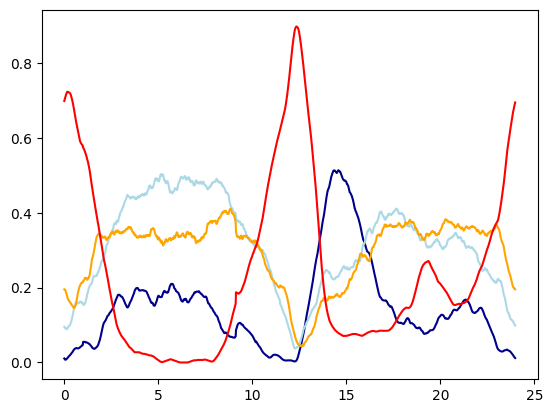

In [10]:
plt = hdf.plot_hmm_overtime(h, 'moving', labels, colours, wrapped = True)
plt.show()

### Section - Quantify the above into box plots and run some quick statistical tests

### Section - Look at the raw data visualised

In [ ]:
def plot_hmm_raw(self, hmm, variable = 'moving', colours = None, num_plots = 5, bin = 60, mago_df = None, func = 'max', show_movement = False, title = ''):
    """ plots the raw dedoded hmm model per fly (total = num_plots) 
        If hmm is a list of hmm objects, the number of plots will equal the length of that list. Use this to compare hmm models.
        """

    if colours is None:
        if isinstance(hmm, list):
            h = hmm[0]
        else:
            h = hmm
        states = h.transmat_.shape[0]
        if states == 4:
            colours = self._colours_four
        else:
            raise RuntimeError(f'Your trained HMM is not 4 states, please provide the {h.transmat_.shape[0]} colours for this hmm. See doc string for more info')

    colours_index = {c : col for c, col in enumerate(colours)}

    if mago_df is not None:
        assert isinstance(mago_df, behavpy) or isinstance(mago_df, behavpy_HMM), 'The mAGO dataframe is not a behavpy or behavpy_HMM class'

    if isinstance(hmm, list):
        num_plots = len(hmm)
        rand_flies = [np.random.permutation(list(set(self.meta.index)))[0]] * num_plots
        h_list = hmm
        if isinstance(bin, list):
            b_list = bin 
        else:
            b_list = [bin] * num_plots
    else:
        rand_flies = np.random.permutation(list(set(self.meta.index)))[:num_plots]
        h_list = [hmm] * num_plots
        b_list = [bin] * num_plots

    df_list = [self.xmv('id', id) for id in rand_flies]
    decoded = [self._hmm_decode(d, h, b, variable, func) for d, h, b in zip(df_list, h_list, b_list)]

    def analyse(data, df_variable):
        states = data[0][0]
        time = data[1][0]
        id = df_variable.index.tolist()
        var = df_variable[variable].tolist()
        previous_states = np.array(states[:-1], dtype = float)
        previous_states = np.insert(previous_states, 0, np.nan)
        previous_var = np.array(var[:-1], dtype = float)
        previous_var = np.insert(previous_var, 0, np.nan)
        all_df = pd.DataFrame(data = zip(id, states, time, var, previous_states, previous_var))
        all_df.columns = ['id','state', 't', 'var','previous_state', 'previous_var']
        all_df.dropna(inplace = True)
        all_df['colour'] = all_df['previous_state'].map(colours_index)
        all_df.set_index('id', inplace = True)
        return all_df

    analysed = [analyse(i, v) for i, v in zip(decoded, df_list)]

    fig = make_subplots(
    rows= num_plots, 
    cols=1,
    shared_xaxes=True, 
    shared_yaxes=True, 
    vertical_spacing=0.02,
    horizontal_spacing=0.02
    )

    for c, (df, b) in enumerate(zip(analysed, b_list)):
        id = df.first_valid_index()
        print(f'Plotting: {id}')
        if mago_df is not None:
            df2 = mago_df.xmv('id', id)
            df2 = df2[df2['has_interacted'] == 1]
            df2['t'] = df2['interaction_t'].map(lambda t:  b * floor(t / b))
            df2.reset_index(inplace = True)
            df = pd.merge(df, df2, how = 'outer', on = ['id', 't'])
            df['colour'] = np.where(df['has_responded'] == True, 'purple', df['colour'])
            df['colour'] = np.where(df['has_responded'] == False, 'lime', df['colour'])
            df['t'] = df['t'].map(lambda t: t / (60*60))
        
        else:
            df['t'] = df['t'].map(lambda t: t / (60*60))

        trace1 = go.Scatter(
            showlegend = False,
            y = df['previous_state'],
            x = df['t'],
            mode = 'markers+lines', 
            marker = dict(
                color = df['colour'],
                ),
            line = dict(
                color = 'black',
                width = 0.5
            )
            )
        fig.add_trace(trace1, row = c+1, col= 1)

        if show_movement == True:
            df['var'] = np.roll((df['var'] * 2) + 0.5, 1)
            trace2 = go.Scatter(
                showlegend = False,
                y = df['var'],
                x = df['t'],
                mode = 'lines', 
                marker = dict(
                    color = 'black',
                    ),
                line = dict(
                    color = 'black',
                    width = 0.75
                )
                )
            fig.add_trace(trace2, row = c+1, col= 1)

    y_range = [-0.2, states-0.8]
    self._plot_ylayout(fig, yrange = y_range, t0 = 0, dtick = False, ylabel = '', title = title)

    fig.update_yaxes(
        showgrid = False,
        linecolor = 'black',
        zeroline = False,
        ticks = 'outside',
        range = y_range, 
        tick0 = 0, 
        dtick = 1,
        tickwidth = 2,
        tickfont = dict(
            size = 18
        ),
        linewidth = 4
    )
    fig.update_xaxes(
        showgrid = False,
        color = 'black',
        linecolor = 'black',
        ticks = 'outside',
        tickwidth = 2,
        tickfont = dict(
            size = 18
        ),
        linewidth = 4
    )

    fig.update_yaxes(
        title = dict(
            text = 'Predicted State',
            font = dict(
                size = 18,
                color = 'black'
            )
        ),
        row = ceil(num_plots/2),
        col = 1
    )

    fig.update_xaxes(
        title = dict(
            text = 'ZT Hours',
            font = dict(
                size = 18,
                color = 'black'
            )
        ),
        row = num_plots,
        col = 1
    )

    return fig